In [2]:
import torch
import os
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch.nn as nn
from torch.nn.functional import relu
from encoder import Encoder
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [3]:
base_dir = os.path.join('Plant_leave_diseases_dataset', 'original')
images_paths = []

In [4]:
# Load the encoder model
def load_encoder(model_path, device):
    model = Encoder()
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    return model

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
encoder_save_path = 'best_models/h1_80-10-10_Encoder.pth'  # Replace with your actual encoder path
encoder = load_encoder(encoder_save_path, device)
encoder.eval()

Encoder(
  (e11): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e21): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e22): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e31): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e32): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e41): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e42): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e51): Conv2d(512, 1024, kernel_siz

In [7]:
data_transforms = {
  'all': transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
  ]),
}

In [8]:
full_dataset = datasets.ImageFolder(base_dir, transform=data_transforms['all'])

In [9]:
indices = list(range(len(full_dataset)))

# Get the directory paths of images
image_paths = [sample[0] for sample in full_dataset.samples]

labels = [os.path.split(os.path.dirname(path))[-1] for path in image_paths]

data = DataLoader(full_dataset, batch_size=4, shuffle=True, num_workers=4)

label_for_PCA = None
latent_vector = None

with torch.no_grad():
  i = 0
  for image, label in data:
    label_for_PCA = label
    image = image.to(device)
    latents = encoder(image)
    latent_vector = latents.cpu()
    i += 1
    if i == 1:
      break

print(label_for_PCA)
print(latent_vector)

tensor([1, 0, 1, 1])
tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.

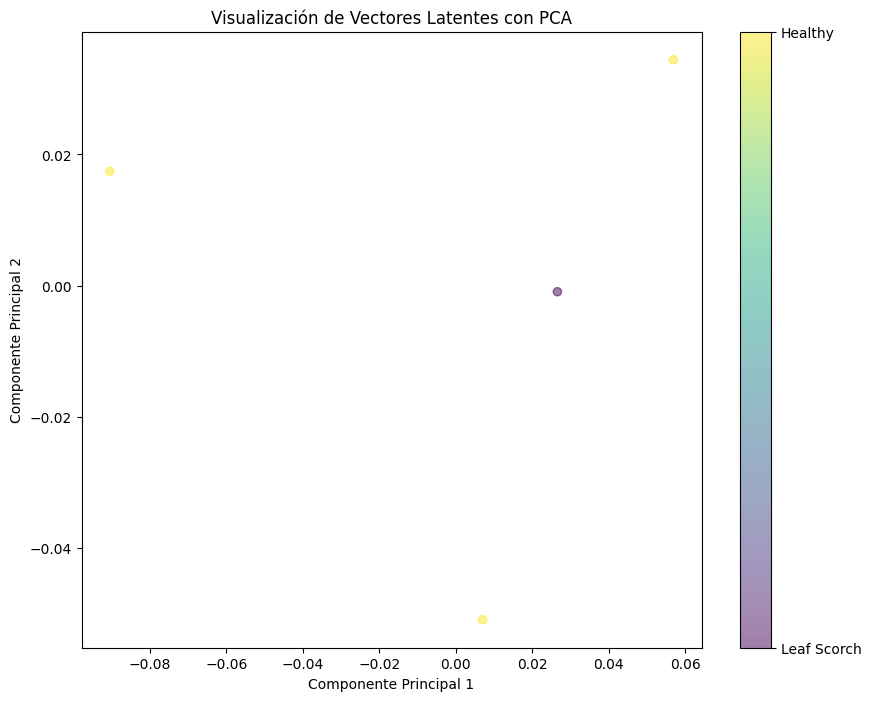

In [12]:

# Convertir los tensores de PyTorch a numpy para usar PCA
latent_vectors_np = latent_vector.detach().cpu().numpy()
labels_np = label_for_PCA.detach().cpu().numpy()

# Asegurarse de que los vectores latentes tengan 2 dimensiones
latent_vectors_flattened = latent_vectors_np.reshape(latent_vectors_np.shape[0], -1)

# Centrar los datos
latent_vectors_centered = latent_vectors_flattened - np.mean(latent_vectors_flattened, axis=0)


pca = PCA(n_components=2)  # Mantener el 85% de la varianza
latent_vectors_pca = pca.fit_transform(latent_vectors_flattened)

# Verificar si sklearn selecciona 2 componentes y visualizar
if pca.n_components_ == 2:
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latent_vectors_pca[:, 0], latent_vectors_pca[:, 1], c=labels_np, cmap='viridis', alpha=0.5)
    cbar = plt.colorbar(scatter)
    cbar.set_ticks([0, 1])
    cbar.set_ticklabels(['Leaf Scorch', 'Healthy'])
    plt.title('Visualización de Vectores Latentes con PCA')
    plt.xlabel('Componente Principal 1')
    plt.ylabel('Componente Principal 2')
    plt.show()
else:
    print(f"sklearn PCA ha reducido los datos a {pca.n_components_} dimensiones para conservar el 85% de la varianza.")


In [11]:
# Convertir los tensores de PyTorch a numpy
latent_vectors_np = latent_vector.detach().cpu().numpy()
labels_np = label_for_PCA.detach().cpu().numpy()

# Reformatear los datos: aplanar las dimensiones espaciales y concatenar lote y canal
latent_vectors_flattened = latent_vectors_np.reshape(latent_vectors_np.shape[0], -1)

# Centrar los datos
latent_vectors_centered = latent_vectors_flattened - np.mean(latent_vectors_flattened, axis=0)

# Calcular la matriz de covarianza
cov_matrix = np.cov(latent_vectors_centered, rowvar=False)

# Calcular los valores propios y los vectores propios
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

# Ordenar los valores propios y los vectores propios
sorted_index = np.argsort(eigenvalues)[::-1]
sorted_eigenvalues = eigenvalues[sorted_index]
sorted_eigenvectors = eigenvectors[:, sorted_index]

# Calcular la varianza explicada acumulada
explained_variances = sorted_eigenvalues / np.sum(sorted_eigenvalues)
cumulative_explained_variance = np.cumsum(explained_variances)

# Seleccionar el número de componentes para alcanzar el 85% de la varianza
num_components = np.argmax(cumulative_explained_variance >= 0.85) + 1

# Seleccionar los vectores propios correspondientes
eigenvector_subset = sorted_eigenvectors[:, 0:num_components]

# Proyectar los datos en los nuevos componentes principales
latent_vectors_reduced = np.dot(latent_vectors_centered, eigenvector_subset)

# Visualizar los datos (solo si num_components es 2)
if num_components == 2:
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latent_vectors_reduced[:, 0], latent_vectors_reduced[:, 1], c=labels_np, cmap='viridis', alpha=0.5)
    plt.colorbar(scatter)
    plt.title('Visualización de Vectores Latentes con PCA Manual')
    plt.xlabel('Componente Principal 1')
    plt.ylabel('Componente Principal 2')
    plt.show()
else:
    print(f"Los datos se han reducido a {num_components} dimensiones para conservar el 85% de la varianza.")



MemoryError: Unable to allocate 300. GiB for an array with shape (200704, 200704) and data type float64